In [1]:
'''
Author: Conor Lane, March 2024
contact: conor.lane1995@gmail.com

Analysis code for calculating the bandwidths and shifts in bandwidths, both for all the active cells at a population level,
and a subset of matched cells that were sound-responsive in both recordings. 

INPUTS: filepath to the evoked cohort megadicts (collected recordings for each condition from Evoked Cohort)
        z_thresh - minimum z-score threshold over which we declare a significant response (default is 4)
'''

'\nAuthor: Conor Lane, March 2024\ncontact: conor.lane1995@gmail.com\n\nAnalysis code for calculating the bandwidths and shifts in bandwidths, both for all the active cells at a population level,\nand a subset of matched cells that were sound-responsive in both recordings. \n\nINPUTS: filepath to the evoked cohort megadicts (collected recordings for each condition from Evoked Cohort)\n        z_thresh - minimum z-score threshold over which we declare a significant response (default is 4)\n'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from scipy.stats import kstest
from collections import Counter
from scipy.stats import sem 

In [3]:
# INPUTS:

filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/megadicts"
z_thresh = 4

LOAD RANDOMIZED STIM COHORT DICTS:

In [4]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

GENERAL FUNCTIONS:

In [5]:
# Plots a double-bar graph for two chosen bandwidth arrays. 
# INPUTS: values_set_1 and 2 - the two sets of bandwidths to compare
#         title - title of graph as string
#         label_1 - first bar label e.g. Pre-Saline
#         label_2 - second bar label

def calculate_relative_frequencies(values, unique_values):
    total_values = len(values)
    frequencies = np.array([np.sum(values == value) / total_values for value in unique_values])
    return frequencies

def plot_comparison(values_set1, values_set2,title,label_1,label_2):
    # Calculate unique values for each set
    unique_values_set1 = np.unique(values_set1)
    unique_values_set2 = np.unique(values_set2)
    
    # Combine unique values from both sets
    unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

    # Halve the unique values except for 0
    halved_unique_values = [value / 2 if value != 0 else 0 for value in unique_values]

    # Calculate relative frequencies for each set based on the unique values
    rel_freq_set1 = calculate_relative_frequencies(values_set1, unique_values)
    rel_freq_set2 = calculate_relative_frequencies(values_set2, unique_values)

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    r1 = np.arange(len(unique_values))
    r2 = [x + bar_width for x in r1]

    # Create the bar plot
    plt.bar(r1, rel_freq_set1, color='blue', width=bar_width, edgecolor='black', label=label_1)
    plt.bar(r2, rel_freq_set2, color='orange', width=bar_width, edgecolor='black', label=label_2)

    # Add labels and title
    plt.xlabel('Bandwidth (Octaves)')
    plt.ylabel('Probability')
    plt.title(title)

    # Set the modified x tick labels
    plt.xticks([r + bar_width / 2 for r in range(len(unique_values))], halved_unique_values)

    # Add legend
    plt.legend()
    plt.tight_layout()

    # Show plot
    plt.show()


In [6]:
# Calculate the bandwidth of the cell using the half-max criterion, i.e. the continous range of responsive frequencies from the max response
# that show a response above 50% of the maximum response.  
# INPUTS:  Tuning array for the specified intensity (e.g. BF_column_1) in get_bandwidth_all_cells func.

def count_above_half_max(array):
    max_value = max(array)
    count = 0
    
    # Find the index of the maximum value in the array
    max_index = array.argmax()
    
    # Start from the index of the maximum value and iterate downwards
    index = max_index
    while index >= 0 and array[index] >= max_value / 2:
        count += 1
        index -= 1
    
    # Start from the index of the maximum value and iterate upwards
    index = max_index + 1  # Start from the next index
    while index < len(array) and array[index] >= max_value / 2:
        count += 1
        index += 1
    
    return count

ALL CELLS FUNCTIONS:

In [7]:
# Calculates the bandwidth of every responsive cell in the cohort for a given condition. 
# Inputs:  dict - the given megadict you want to extract bandwidths from.
#          Intensity - The intensity of sound stim you want in dB (0 = 35, 1 = 50, 2 = 65, 3 = 80)
# Returns: List containing the bandwidth value (in no. of frequencies so bandwidth of 1 = 0.5 octaves)

def get_bandwidth_all_cells(dict,intensity):    
    
    # Get a list of all the individual recording keys as strings
    sub_dict_keys = dict.keys()

    bandwidth_all = []
    
    # Iterate through each cell, in each individual recording. 
    for sub_dict in sub_dict_keys:
        for cell in dict[sub_dict]:
                
                # Select only the responsive cells
                if dict[sub_dict][cell]['active'] == True:

                    # Extract the tuning information from the dict and isolate only the specified intensity. 
                    tuning_array_1 = dict[sub_dict][cell]['peak_tuning']
                    BF_column_1 = tuning_array_1[:,intensity]

                    # If the cell has a response at this sound intensity that is above z-score threshold,
                    # calculate the bandwidth using half_max function
                    if any(value >= z_thresh for value in BF_column_1):
                        bandwidth = count_above_half_max(BF_column_1)
                        bandwidth_all.append(bandwidth)

    return bandwidth_all

In [8]:
def get_counts(BF_list):
    counts = Counter(BF_list)
    keys = list(counts.keys())
    keys = sorted(keys)
    counts_sorted = {i: counts[i] for i in keys}
    counts_sorted_density = {k: v / len(BF_list) for k, v in counts_sorted.items()}

    return counts_sorted_density

In [9]:
# Calculates the bandwidth of every responsive cell in the cohort for a given condition. 
# Inputs:  dict - the given megadict you want to extract bandwidths from.
#          Intensity - The intensity of sound stim you want in dB (0 = 35, 1 = 50, 2 = 65, 3 = 80)
# Returns: List containing the bandwidth value (in no. of frequencies so bandwidth of 1 = 0.5 octaves)

def get_bandwidth_all_cells_inmouse(dict,intensity):    
    
    # Get a list of all the individual recording keys as strings
    sub_dict_keys = dict.keys()

    bandwidth_array = np.zeros([len(sub_dict_keys),12])
    keys = np.arange(0,12,1)
    
    # Iterate through each cell, in each individual recording. 
    for i,sub_dict in enumerate(sub_dict_keys):

        bandwidth_list = []

        for cell in dict[sub_dict]:
                
                # Select only the responsive cells
                if dict[sub_dict][cell]['active'] == True:

                    # Extract the tuning information from the dict and isolate only the specified intensity. 
                    tuning_array_1 = dict[sub_dict][cell]['peak_tuning']
                    BF_column_1 = tuning_array_1[:,intensity]

                    # If the cell has a response at this sound intensity that is above z-score threshold,
                    # calculate the bandwidth using half_max function
                    if any(value >= z_thresh for value in BF_column_1):
                        bandwidth = count_above_half_max(BF_column_1)
                        bandwidth_list.append(bandwidth)
        bandwidth_counts = get_counts(bandwidth_list)
        for key in keys:
            bandwidth_counts.setdefault(key, 0)
        bandwidth_array[i,:] = list(bandwidth_counts.values())
    bandwidth_mean = np.mean(bandwidth_array,axis=0)
    bandwidth_sem = sem(bandwidth_array,axis=0)

    return bandwidth_array,bandwidth_mean,bandwidth_sem

MATCHED CELLS FUNCTIONS:

In [10]:
pre_saline_test = get_bandwidth_all_cells_inmouse(saline_pre,2)
post_saline_test = get_bandwidth_all_cells_inmouse(saline_post,2)

bandwidth_array_pre,bandwidth_mean_pre,bandwidth_sem_pre = pre_saline_test
bandwidth_array_post,bandwidth_mean_post,bandwidth_sem_post = post_saline_test

In [11]:
# Create an array of all the matched cells that are sound-responsive in both recordings.  Each row is a matched cell pair. 
# INPUTS:  pre- and post- megadicts for a given drug condition. 
#          The specific recording to get matched cells for in the sub-dictionaries of pre- and post.
#          Code is written to be used with the matched cells bandwidth functions. 
# OUTPUTS: (npairs x 2) array containing the matched cell pairs that were responsive in both recordings. 

def get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post):

    matched_responsive_1 = []
    matched_responsive_2 = []

    # Get the array of matched cell pairs stored under the dictionary's first cell key. 
    matched_cells = dict_post[sub_dict_post][next(iter(dict_post[sub_dict_post]))]['matched_cells']

    # iterate through each cell in the first dict and check if it is a matched cell pair.  Append the matched cells to a list.
    for cell in dict_pre[sub_dict_pre]:
            if cell in matched_cells[:,0] and dict_pre[sub_dict_pre][cell]['active'] == True:
                matched_responsive_1.append(cell)

    # Same operation but with the second dictionary.
    for cell in dict_post[sub_dict_post]:
            if cell in matched_cells[:,1] and dict_post[sub_dict_post][cell]['active'] == True:
                matched_responsive_2.append(cell)

    indices = np.where(np.isin(matched_cells[:, 0], matched_responsive_1))

    # Find the indices where the values in column 0 appear in the first match list.
    indices_col1 = np.isin(matched_cells[:, 0], matched_responsive_1)

    # Find the indices where the values in column 1 appear in the second match list. 
    indices_col2 = np.isin(matched_cells[:, 1], matched_responsive_2)

    # Combine the two conditions using logical AND
    combined_indices = np.logical_and(indices_col1, indices_col2)

    # Extract the rows where both conditions are true
    coactive = matched_cells[combined_indices]

    return coactive


In [12]:
# Extract the bandwidths of the matched cell pairs across all recordings of that condition.  
# INPUTS:  pre- and post-drug dictionaries to extract bandwidths.
#          intensity - The intensity of sound stim you want in dB (0 = 35, 1 = 50, 2 = 65, 3 = 80)
# OUTPUTS: (npairs x 2) array containing the pre- and post-bandwidths of every cell pair.  

def get_bandwidth_matched_cells(dict_pre,dict_post,intensity):

    matched_bandwidths = []

    for sub_dict_pre, sub_dict_post in zip(dict_pre.keys(),dict_post.keys()):
        
        # Get the array of consistently responsive matched cell pairs for the pre- and post-conditions. 
        coactive = get_consistently_responsive_cells(dict_pre,dict_post,sub_dict_pre,sub_dict_post)

        # Initialize empty array to place bandwidths in.
        bandwidth = np.zeros_like(coactive)

        # For each pair of cells in the coactive matrix, extract their tuning curves. i keeps track of the pair's row position. 
        for i,cell_1, cell_2 in zip(range(len(coactive[:,0])),coactive[:,0],coactive[:,1]):
                    tuning_array_1 = dict_pre[sub_dict_pre][cell_1]['peak_tuning']
                    tuning_array_2 = dict_post[sub_dict_post][cell_2]['peak_tuning']

                    # Extract the full row of frequencies, at the selected intensity.
                    column_pre = tuning_array_1[:,intensity]
                    column_post = tuning_array_2[:,intensity]

                    # Calculate the bandwidths from each tuning array. 
                    bandwidth[i,0] = count_above_half_max(column_pre)
                    bandwidth[i,1] = count_above_half_max(column_post)

        matched_bandwidths.append(bandwidth)

    matched_bandwidths = np.concatenate(matched_bandwidths)

    return matched_bandwidths

In [13]:
# Calculate the shift in bandwidth in matched cells by subtracting post bandwidths from pre. 

def get_bandwidth_shift(matched_bandwidths):
    bandwidth_change = matched_bandwidths[:,1] - matched_bandwidths[:,0]

    return bandwidth_change

ANALYSIS 1: BANDWIDTHS ALL CELLS

In [14]:
# Calculate the bandwidth for all cells in a particular dictionary at a specific intensity. Change dicts as needed. 

saline_pre_bandwidth_65 = get_bandwidth_all_cells(saline_pre,2)
saline_post_bandwidth_65 = get_bandwidth_all_cells(saline_post,2)

psilo_pre_bandwidth_65 = get_bandwidth_all_cells(psilo_pre,2)
psilo_post_bandwidth_65 = get_bandwidth_all_cells(psilo_post,2)

saline_pre_bandwidth_80 = get_bandwidth_all_cells(saline_pre,3)
saline_post_bandwidth_80 = get_bandwidth_all_cells(saline_post,3)

psilo_pre_bandwidth_80 = get_bandwidth_all_cells(psilo_pre,3)
psilo_post_bandwidth_80 = get_bandwidth_all_cells(psilo_post,3)

In [15]:
#  Not normally distributed so Mann Whitney test for difference. 

from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(psilo_pre_bandwidth_80,psilo_post_bandwidth_80)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 69530.5
P-value: 0.2872967521848092


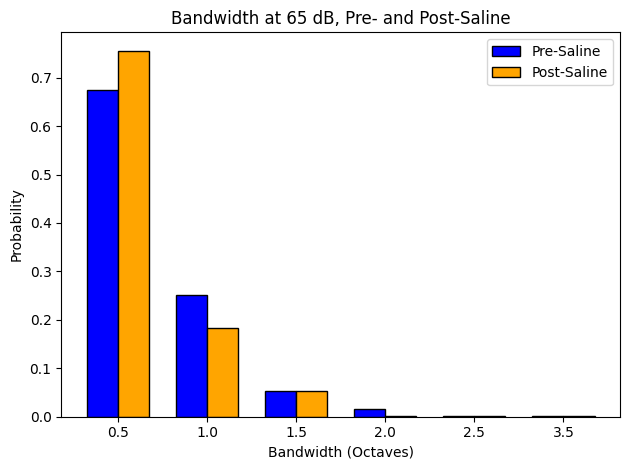

In [16]:
# Plot the comparison of bandwidths, change title and labels as needed. 

title = 'Bandwidth at 65 dB, Pre- and Post-Saline'
label_1 = 'Pre-Saline'
label_2 = 'Post-Saline'
plot_comparison(saline_pre_bandwidth_65,saline_post_bandwidth_65,title,label_1,label_2)

In [24]:
print(saline_pre_bandwidth_65)

[1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 5, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 3, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 2, 2, 1, 3, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1, 1, 3, 4, 1, 2, 1, 1, 3, 2, 1, 7, 1, 1, 1, 1, 3, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 2, 2, 1, 4, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 4, 4, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 

In [17]:
def calculate_relative_frequencies(values, unique_values):
    total_values = len(values)
    frequencies = np.array([np.sum(values == value) / total_values for value in unique_values])
    return frequencies

In [18]:
def plot_comparison(values_set1, values_set2,title,label_1,label_2):
    # Calculate unique values for each set
    unique_values_set1 = np.unique(values_set1)
    unique_values_set2 = np.unique(values_set2)
    
    # Combine unique values from both sets
    unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

    # Halve the unique values except for 0
    halved_unique_values = [value / 2 if value != 0 else 0 for value in unique_values]

    # Calculate relative frequencies for each set based on the unique values
    rel_freq_set1 = calculate_relative_frequencies(values_set1, unique_values)
    rel_freq_set2 = calculate_relative_frequencies(values_set2, unique_values)


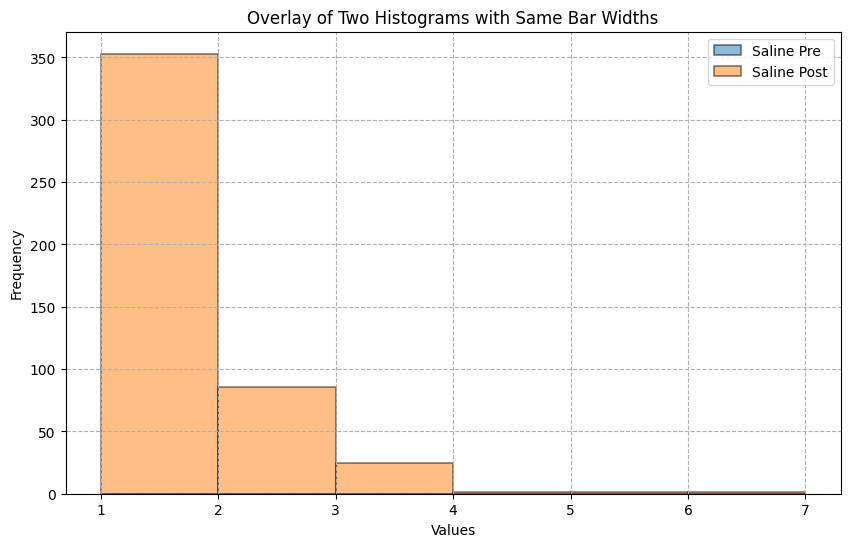

In [19]:
# Calculate unique values for each set
unique_values_set1 = np.unique(saline_pre_bandwidth_65)
unique_values_set2 = np.unique(saline_post_bandwidth_65)
    
    # Combine unique values from both sets
unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

    # Halve the unique values except for 0
halved_unique_values = [value / 2 if value != 0 else 0 for value in unique_values]

    # Calculate relative frequencies for each set based on the unique values
rel_freq_set1 = calculate_relative_frequencies(saline_pre_bandwidth_65, unique_values)
rel_freq_set2 = calculate_relative_frequencies(saline_post_bandwidth_65, unique_values)

# Setting up bins for histograms (adjust as needed)
bins = np.arange(min(min(saline_pre_bandwidth_65), min(saline_post_bandwidth_65)), 
                 max(max(saline_pre_bandwidth_65), max(saline_post_bandwidth_65)) + 1, 1)

# Plotting histograms with same bins and same width
plt.figure(figsize=(10, 6))

plt.hist(rel_freq_set1, bins=bins, alpha=0.5, label='Saline Pre', edgecolor='black', linewidth=1.2)
plt.hist(saline_post_bandwidth_65, bins=bins, alpha=0.5, label='Saline Post', edgecolor='black', linewidth=1.2)

# Customizing labels and title
plt.title('Overlay of Two Histograms with Same Bar Widths')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--')

plt.show()


In [19]:
print(rel_freq_set2)

[0.75588865 0.18415418 0.05353319 0.00214133 0.00214133 0.00214133]


In [20]:
def calculate_cdf(data):
    # Define your series
    s = pd.Series(data, name = 'value')
    df = pd.DataFrame(s)
    # Get the frequency, PDF and CDF for each value in the series

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    stats_df

    return stats_df

In [21]:
def plot_cdf(pre,post,title,label_1,label_2):
    pre_cdf = calculate_cdf(pre)
    post_cdf = calculate_cdf(post)

    label = [label_1,label_2]

    zipped = zip([pre_cdf,post_cdf], label)

    fig = plt.figure()

    for frame,label in zipped:
        plt.plot(frame['value'], frame['cdf'],label = label )
    plt.title(title,pad=10)
    # plt.xticks(range(4), [35,50,65,80])
    plt.xlabel("Bandwidth")
    plt.ylabel("Cumulative Probability")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
saline_pre_bandwidth = []

for i in range(3, -1, -1):
    saline_pre_list = get_bandwidth_all_cells(saline_pre,i)
    octaves = [x / 2 for x in saline_pre_list]
    saline_pre_bandwidth.append(octaves)

saline_post_bandwidth = []

for i in range(3, -1, -1):
    saline_post_list = get_bandwidth_all_cells(saline_post,i)
    octaves = [x / 2 for x in saline_post_list]
    saline_post_bandwidth.append(octaves)



psilo_pre_bandwidth = []

for i in range(3, -1, -1):
    psilo_pre_list = get_bandwidth_all_cells(psilo_pre,i)
    octaves = [x / 2 for x in psilo_pre_list]
    psilo_pre_bandwidth.append(octaves)

psilo_post_bandwidth = []

for i in range(3, -1, -1):
    psilo_post_list = get_bandwidth_all_cells(psilo_post,i)
    octaves = [x / 2 for x in psilo_post_list]
    psilo_post_bandwidth.append(octaves)

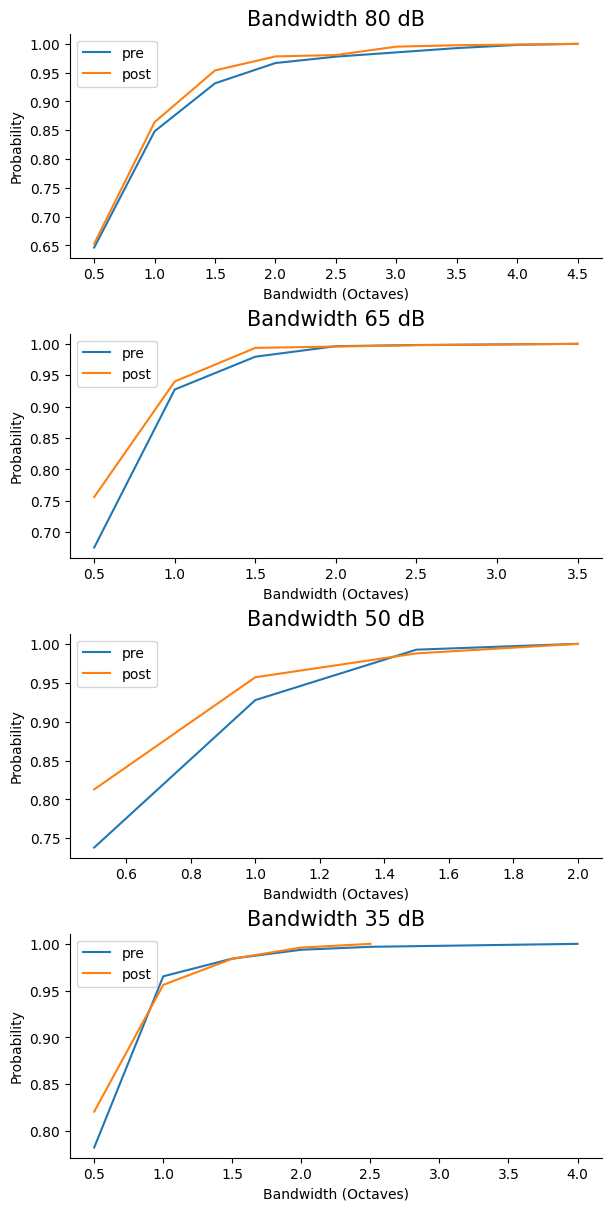

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=([6,12]),constrained_layout=True)
axes = axes.flatten()
decibels = ['80 dB','65 dB','50 dB','35 dB']

# Loop through each subplot
for i, ax in enumerate(axes[:4]):  # Looping through first 4 subplots
    pre_cdf = calculate_cdf(saline_pre_bandwidth[i])
    post_cdf = calculate_cdf(saline_post_bandwidth[i])
    
    # Plot pre_cdf and post_cdf on the same subplot
    ax.plot(pre_cdf['value'], pre_cdf['cdf'], label='pre')
    ax.plot(post_cdf['value'], post_cdf['cdf'], label='post')
    
    # Set title and legend for each subplot
    ax.set_title('Bandwidth ' + decibels[i], fontsize=15)
    ax.legend()
    
    ax.set_xlabel('Bandwidth (Octaves)')
    ax.set_ylabel('Probability')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

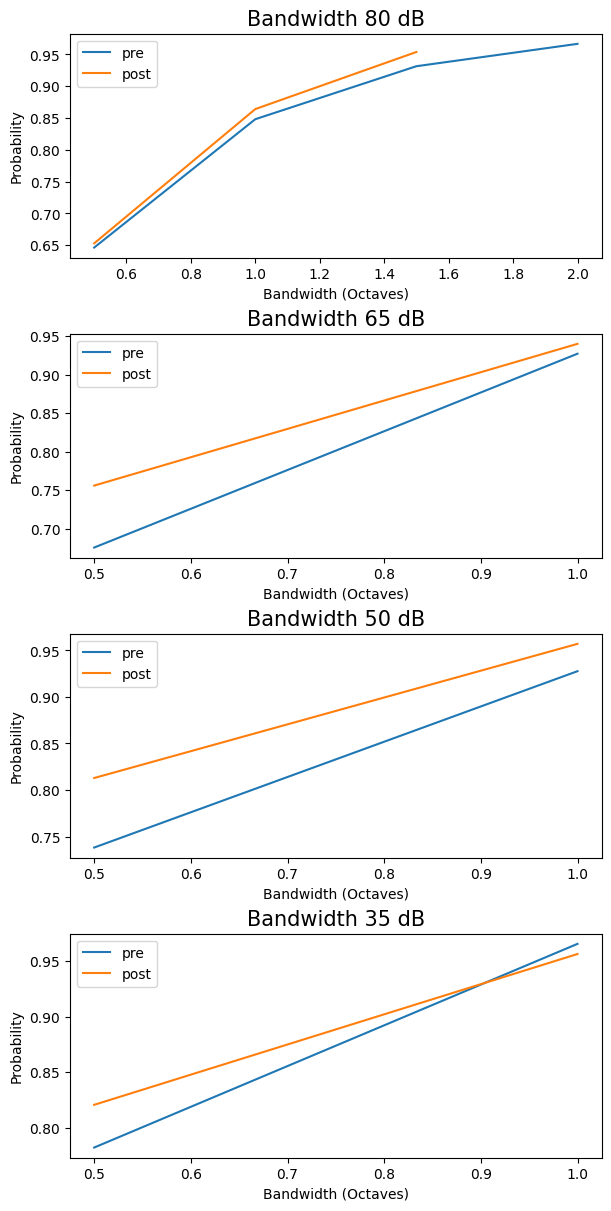

In [24]:
# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=([6,12]),constrained_layout=True)
axes = axes.flatten()
decibels = ['80 dB','65 dB','50 dB','35 dB']
# Loop through each subplot
for i, ax in enumerate(axes[:4]):  # Looping through first 4 subplots
    pre_cdf = calculate_cdf(saline_pre_bandwidth[i])
    post_cdf = calculate_cdf(saline_post_bandwidth[i])
    
    # Filter data points where 'cdf' is less than or equal to 0.99
    pre_cdf_filtered = pre_cdf[(pre_cdf['cdf'] <= 0.97)]
    post_cdf_filtered = post_cdf[(post_cdf['cdf'] <= 0.97)]
    
    # Plot pre_cdf and post_cdf on the same subplot
    ax.plot(pre_cdf_filtered['value'], pre_cdf_filtered['cdf'], label='pre')
    ax.plot(post_cdf_filtered['value'], post_cdf_filtered['cdf'], label='post')
    
    # Set title and legend for each subplot
    ax.set_title('Bandwidth ' + decibels[i], fontsize=15)
    ax.legend()
    
    ax.set_xlabel('Bandwidth (Octaves)')
    ax.set_ylabel('Probability')

plt.show()

In [25]:
def filter_list_by_frequency(input_list, threshold):
    # Step 1: Calculate frequency of each value in the list
    freq = Counter(input_list)
    
    # Step 2: Determine the count threshold
    count_threshold = len(input_list) * threshold
    
    # Step 3: Filter the list based on the threshold
    filtered_list = [value for value in input_list if freq[value] >= count_threshold]
    
    return filtered_list

In [26]:
saline_post_bandwidth_65_filtered = filter_list_by_frequency(saline_post_bandwidth_65,0.01)
saline_pre_bandwidth_65_filtered = filter_list_by_frequency(saline_pre_bandwidth_65,0.01)

In [27]:
print(Counter(saline_post_bandwidth_65))
print(Counter(saline_pre_bandwidth_65))

Counter({1: 353, 2: 86, 3: 25, 7: 1, 4: 1, 5: 1})
Counter({1: 362, 2: 135, 3: 28, 4: 9, 5: 1, 7: 1})


ANALYSIS 2: BANDWIDTH MATCHED CELLS SUBSET

In [28]:
# Get the bandwidths for the matched cells, column 0 is pre, 1 is post. 

saline_matched_65 = get_bandwidth_matched_cells(saline_pre,psilo_post,1)

In [29]:
title = 'Bandwidth Matched Cells at 65 dB, Pre- and Post-Saline'
label_1 = 'Pre-Saline'
label_2 = 'Post-Saline'
plot_comparison(saline_matched_65[:,0],saline_matched_65[:,1],title,label_1,label_2)

ANALYSIS 2: MATCHED CELLS CHANGE IN BANDWIDTH

In [30]:
# Get change in bandwidth for both the saline and psilocybin conditions. 

change_bandwidth_saline_65 = get_bandwidth_shift(get_bandwidth_matched_cells(saline_pre,saline_post,0))
change_bandwidth_psilo_65 = get_bandwidth_shift(get_bandwidth_matched_cells(psilo_pre,psilo_post,0))


In [31]:
title = 'Change in Bandwidth at 65 dB, Saline vs Psilocybin'
label_1 = 'Saline'
label_2 = 'Psilocybin'
plot_comparison(change_bandwidth_saline_65,change_bandwidth_psilo_65,title,label_1,label_2)

In [32]:
#  Not normally distributed so Mann Whitney test for difference. 

from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(psilo_pre_bandwidth_50,psilo_post_bandwidth_50)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

NameError: name 'psilo_pre_bandwidth_50' is not defined

In [33]:
# Perform KS test between two samples
ks_statistic, p_value = kstest(change_bandwidth_saline_65,change_bandwidth_psilo_65)

# Print test results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.0448709223719432
P-value: 0.9445527578034196


In [34]:
print(Counter(saline_pre_bandwidth_65))

Counter({1: 362, 2: 135, 3: 28, 4: 9, 5: 1, 7: 1})


In [35]:
def get_counts_equal(data):
    bands = [1,2,3,4,5]
    counts = Counter(data)

    for key in bands:
        counts.setdefault(key, 0)
    sorted_keys = sorted(counts.keys())
    counts = {k: counts[k] for k in sorted_keys}
    counts = {k: v for k, v in counts.items() if k in bands}
    return counts

In [51]:
# Calculate the bandwidth for all cells in a particular dictionary at a specific intensity. Change dicts as needed. 

saline_pre_bandwidth_80 = get_bandwidth_all_cells(saline_pre,3)

saline_post_bandwidth_80 = get_bandwidth_all_cells(saline_post,3)


psilo_pre_bandwidth_80 = get_bandwidth_all_cells(psilo_pre,3)

psilo_post_bandwidth_80 = get_bandwidth_all_cells(psilo_post,3)


saline_pre_bandwidth_65 = get_bandwidth_all_cells(saline_pre,2)

saline_post_bandwidth_65 = get_bandwidth_all_cells(saline_post,2)

psilo_pre_bandwidth_65 = get_bandwidth_all_cells(psilo_pre,2)

psilo_post_bandwidth_65 = get_bandwidth_all_cells(psilo_post,2)

saline_pre_bandwidth_50 = get_bandwidth_all_cells(saline_pre,1)
saline_post_bandwidth_50 = get_bandwidth_all_cells(saline_post,1)

psilo_pre_bandwidth_50 = get_bandwidth_all_cells(psilo_pre,1)
psilo_post_bandwidth_50 = get_bandwidth_all_cells(psilo_post,1)

saline_pre_bandwidth_35 = get_bandwidth_all_cells(saline_pre,0)

saline_post_bandwidth_35 = get_bandwidth_all_cells(saline_post,0)

psilo_pre_bandwidth_35 = get_bandwidth_all_cells(psilo_pre,0)

psilo_post_bandwidth_35 = get_bandwidth_all_cells(psilo_post,0)
print(len(saline_pre_bandwidth_35))

317


In [37]:
#  Not normally distributed so Mann Whitney test for difference. 

from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(saline_pre_bandwidth_35,psilo_pre_bandwidth_35)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 46795.0
P-value: 0.18659660855277682


C:\Users\Conor\AppData\Local\Temp\ipykernel_19072\3274807680.py:55: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


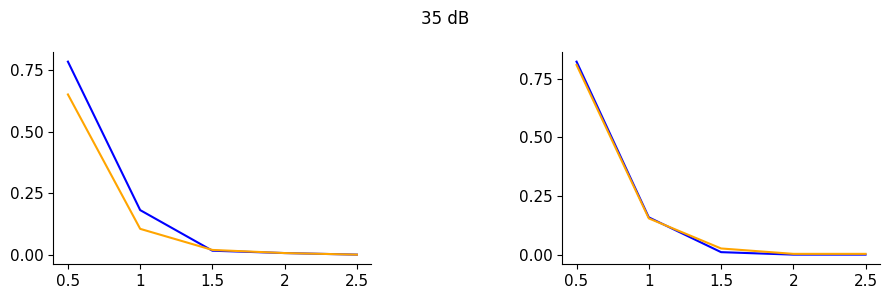

In [60]:
pre1 = saline_pre_bandwidth_35
post1 = saline_post_bandwidth_35
pre2 = psilo_pre_bandwidth_35
post2 = psilo_post_bandwidth_35

title = "35 dB"

pre1_counts = get_counts_equal(pre1)
post1_counts = get_counts_equal(post1)
pre2_counts = get_counts_equal(pre2)
post2_counts = get_counts_equal(post2)

pre1_rel = {k: v / len(pre1) for k,v in pre1_counts.items()}
post1_rel = {k: v / len(pre1) for k,v in post1_counts.items()}
pre2_rel = {k: v / len(pre2) for k,v in pre2_counts.items()}
post2_rel = {k: v / len(post2) for k,v in post2_counts.items()}

pre1_list = list(pre1_rel.values())
post1_list = list(post1_rel.values())
pre2_list = list(pre2_rel.values())
post2_list = list(post2_rel.values())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=([9, 3]), constrained_layout=True)

axes[0].plot(pre1_list, color='b')
axes[0].plot(post1_list, color='orange')
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_xticklabels([0.5, 1, 1.5, 2, 2.5], fontsize=11)
axes[0].set_yticks([0, 0.25, 0.5, 0.75])
# axes[0].set_ylabel("Proportion of population", fontsize=11)
# axes[0].set_xlabel("Bandwidth (Octaves)")

axes[1].plot(pre2_list, color='b', label='Pre')
axes[1].plot(post2_list, color='orange', label='Post')
axes[1].set_xticks([0, 1, 2, 3, 4])
axes[1].set_yticks([0, 0.25, 0.5, 0.75])
axes[1].set_xticklabels([0.5, 1, 1.5, 2, 2.5], fontsize=11)
# axes[1].set_ylabel("Proportion of population", fontsize=11)
# axes[1].set_xlabel("Bandwidth (Octaves)")
# axes[1].legend(fontsize=11)

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[0].tick_params(axis='y', labelsize=11)
axes[1].tick_params(axis='y', labelsize=11)

fig.suptitle(title)

# Add space between the subplots


plt.tight_layout()
fig.subplots_adjust(wspace=0.6)

plt.show()


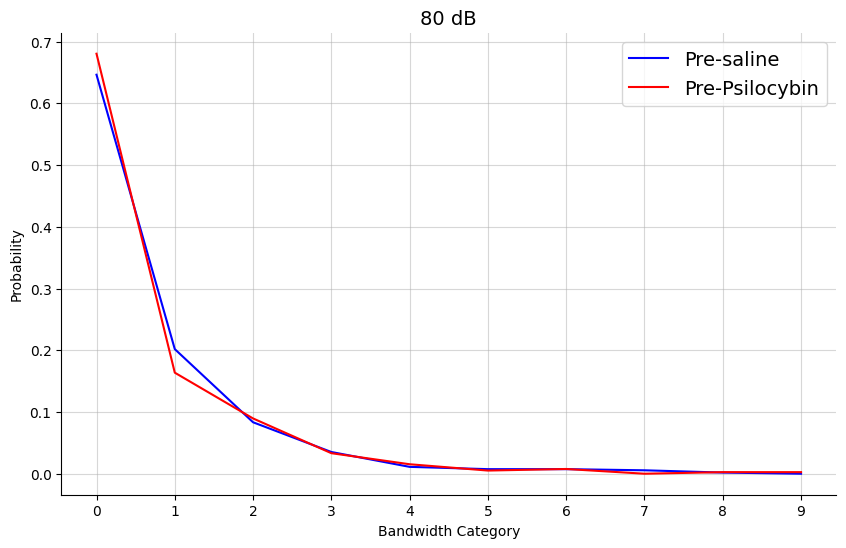

In [39]:
import matplotlib.pyplot as plt
import numpy as np


data1 = saline_pre_bandwidth_80
data2 = psilo_pre_bandwidth_80
title = "80 dB"

# Calculate unique values for each set
unique_values_set1 = np.unique(data1)
unique_values_set2 = np.unique(data2)


# Combine unique values from both sets
unique_values = np.unique(np.concatenate((unique_values_set1, unique_values_set2)))

# Halve the unique values except for 0
halved_unique_values = [value / 2 if value != 0 else 0 for value in unique_values]

# Calculate relative frequencies for each set based on the unique values
rel_freq_set1 = calculate_relative_frequencies(data1, unique_values)
rel_freq_set2 = calculate_relative_frequencies(data2, unique_values)

# Your first set of probability data
data1 = rel_freq_set1

# Your second set of probability data
data2 = rel_freq_set2

# Generate x values corresponding to the data points
x1 = np.arange(len(data1))
x2 = np.arange(len(data2))

# Plotting
plt.figure(figsize=(10, 6))


# Plot the first set of data
plt.plot(x1, data1, linestyle='-', color='b', label='Pre-saline')

# Plot the second set of data
plt.plot(x2, data2, linestyle='-', color='r', label='Pre-Psilocybin')

# Customize x-tick labels if needed
bandwidth_categories = np.arange(len(data1))  # Example categories based on the length of data1
plt.xticks(ticks=np.arange(len(data1)), labels=bandwidth_categories)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Bandwidth Category')
plt.ylabel('Probability')
plt.title(title,fontsize=14)

# Add a legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True,alpha=0.5)
plt.show()

In [43]:
#  Not normally distributed so Mann Whitney test for difference. 

from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(saline_pre_bandwidth_35,saline_post_bandwidth_35)

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U statistic: 41186.0
P-value: 0.3000406190558025
